Anamoly detection of Time-Series for Predictive Maintenance:
The notebook includes
1. traditional methods
2. Dimension reduction using PCA

Importing necessary libraries using pandas, scikit learn and keras

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

Loading dataset from a directory

In [10]:
telemetry = pd.read_csv(r'D:\02_Work\04_projects\Predicitve maintenance\Predictive-Maintainence-using-Data-Analysis-and-Time-Series-Forecasting-main\dataset\PdM_telemetry.csv')
errors = pd.read_csv(r'D:\02_Work\04_projects\Predicitve maintenance\Predictive-Maintainence-using-Data-Analysis-and-Time-Series-Forecasting-main\dataset\PdM_errors.csv')
failures = pd.read_csv(r'D:\02_Work\04_projects\Predicitve maintenance\Predictive-Maintainence-using-Data-Analysis-and-Time-Series-Forecasting-main\dataset\PdM_failures.csv')
maint = pd.read_csv(r'D:\02_Work\04_projects\Predicitve maintenance\Predictive-Maintainence-using-Data-Analysis-and-Time-Series-Forecasting-main\dataset\PdM_maint.csv')
machines = pd.read_csv(r'D:\02_Work\04_projects\Predicitve maintenance\Predictive-Maintainence-using-Data-Analysis-and-Time-Series-Forecasting-main\dataset\PdM_machines.csv')

print("Data successfully loaded")

Data successfully loaded


Examining multiple machines.
Identifying which sensor data gives the most predictive failures.
Undestanding the temporal patterns in the sensor data.

Failures per machine:
machineID
1       7
2       4
3       5
4       6
5       7
       ..
96      5
97      8
98     16
99     19
100     3
Name: count, Length: 98, dtype: int64


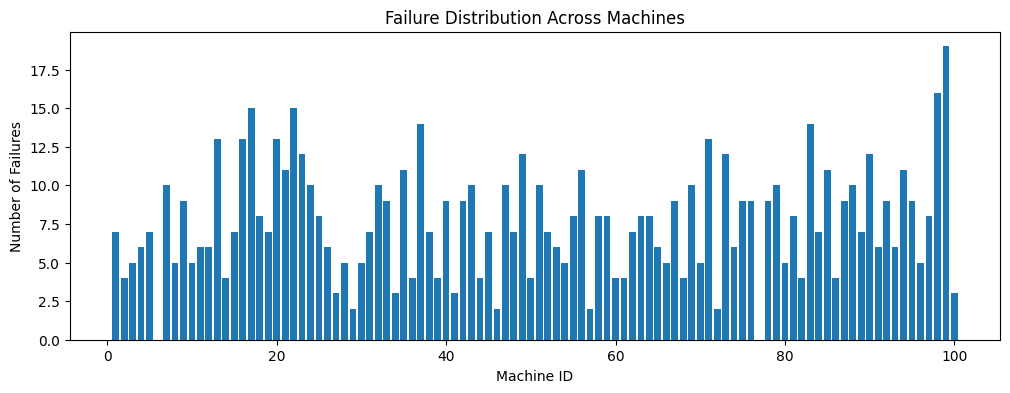

In [11]:
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])
failures['datetime'] = pd.to_datetime(failures['datetime'])
errors['datetime'] = pd.to_datetime(errors['datetime'])

failure_counts = failures['machineID'].value_counts().sort_index()
print("Failures per machine:")
print(failure_counts)

plt.figure(figsize=(12, 4))
plt.bar(failure_counts.index, failure_counts.values)
plt.xlabel('Machine ID')
plt.ylabel('Number of Failures')
plt.title('Failure Distribution Across Machines')
plt.show()

Selecting machines with good history of sensor data for machine learning model training. So machines with few failures are selected. so machines with 2 -4 failures are selected for good reliability.

In [12]:
selected_machines = failure_counts[(failure_counts >= 2) & (failure_counts <= 4)].index.tolist()
print(f"Selected {len(selected_machines)} machines for analysis: {selected_machines}")

Selected 19 machines for analysis: [2, 14, 27, 29, 34, 36, 39, 41, 44, 46, 50, 57, 60, 61, 68, 72, 82, 86, 100]


In [13]:
df_sel = telemetry[telemetry['machineID'] == 14].reset_index(drop=True)
sel_fail = failures[failures['machineID'] == 14].reset_index(drop=True)
sel_err = errors[errors['machineID'] == 14].reset_index(drop=True)

print(f"\nMachine 14 statistics:")
print(f"Telemetry records: {len(df_sel)}")
print(f"Failures: {len(sel_fail)}")
print(f"Errors: {len(sel_err)}")
print(f"\nFailure dates:")
print(sel_fail[['datetime', 'failure']])


Machine 14 statistics:
Telemetry records: 8761
Failures: 4
Errors: 38

Failure dates:
             datetime failure
0 2015-01-31 06:00:00   comp2
1 2015-03-02 06:00:00   comp1
2 2015-07-15 06:00:00   comp1
3 2015-07-30 06:00:00   comp2


Visualization of sensor reading around a failure event for a specific machine. Around 10 days.

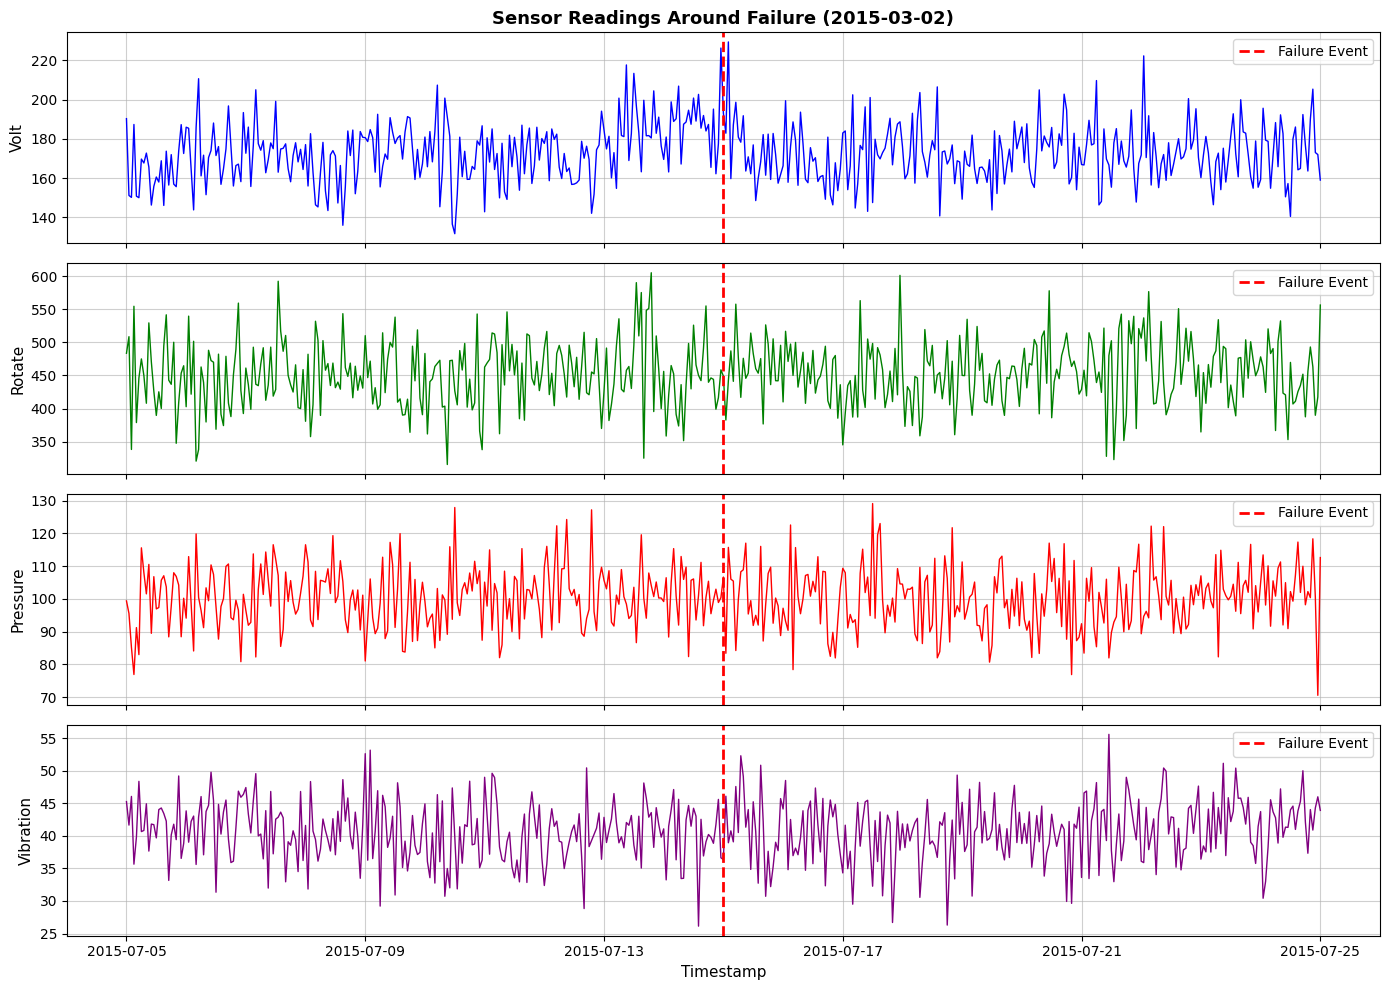

In [ ]:
df_sel['datetime'] = pd.to_datetime(df_sel['datetime'])

# Selecting the failure on 2015-07-15
st = df_sel[df_sel['datetime'] == "2015-07-15"].index[0]

# Extracting 10 days before and after
window = df_sel.loc[st-(10*24):st+(10*24), :]

# Plot all 4 sensors in a single fingure
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

sensors = ['volt', 'rotate', 'pressure', 'vibration']
colors = ['blue', 'green', 'red', 'purple']

for ax, sensor, color in zip(axes, sensors, colors):
    ax.plot(window['datetime'], window[sensor], color=color, linewidth=1)
    ax.axvline(window.iloc[10*24]['datetime'], color='red', linestyle='--', linewidth=2, label='Failure Event')
    ax.set_ylabel(sensor.capitalize(), fontsize=11)
    ax.grid(alpha=0.6)
    ax.legend()

axes[-1].set_xlabel('Timestamp', fontsize=11)
axes[0].set_title('Sensor Readings Around Failure (2015-03-02)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

Check for any anamoly in the above sensor values using rolling statistics

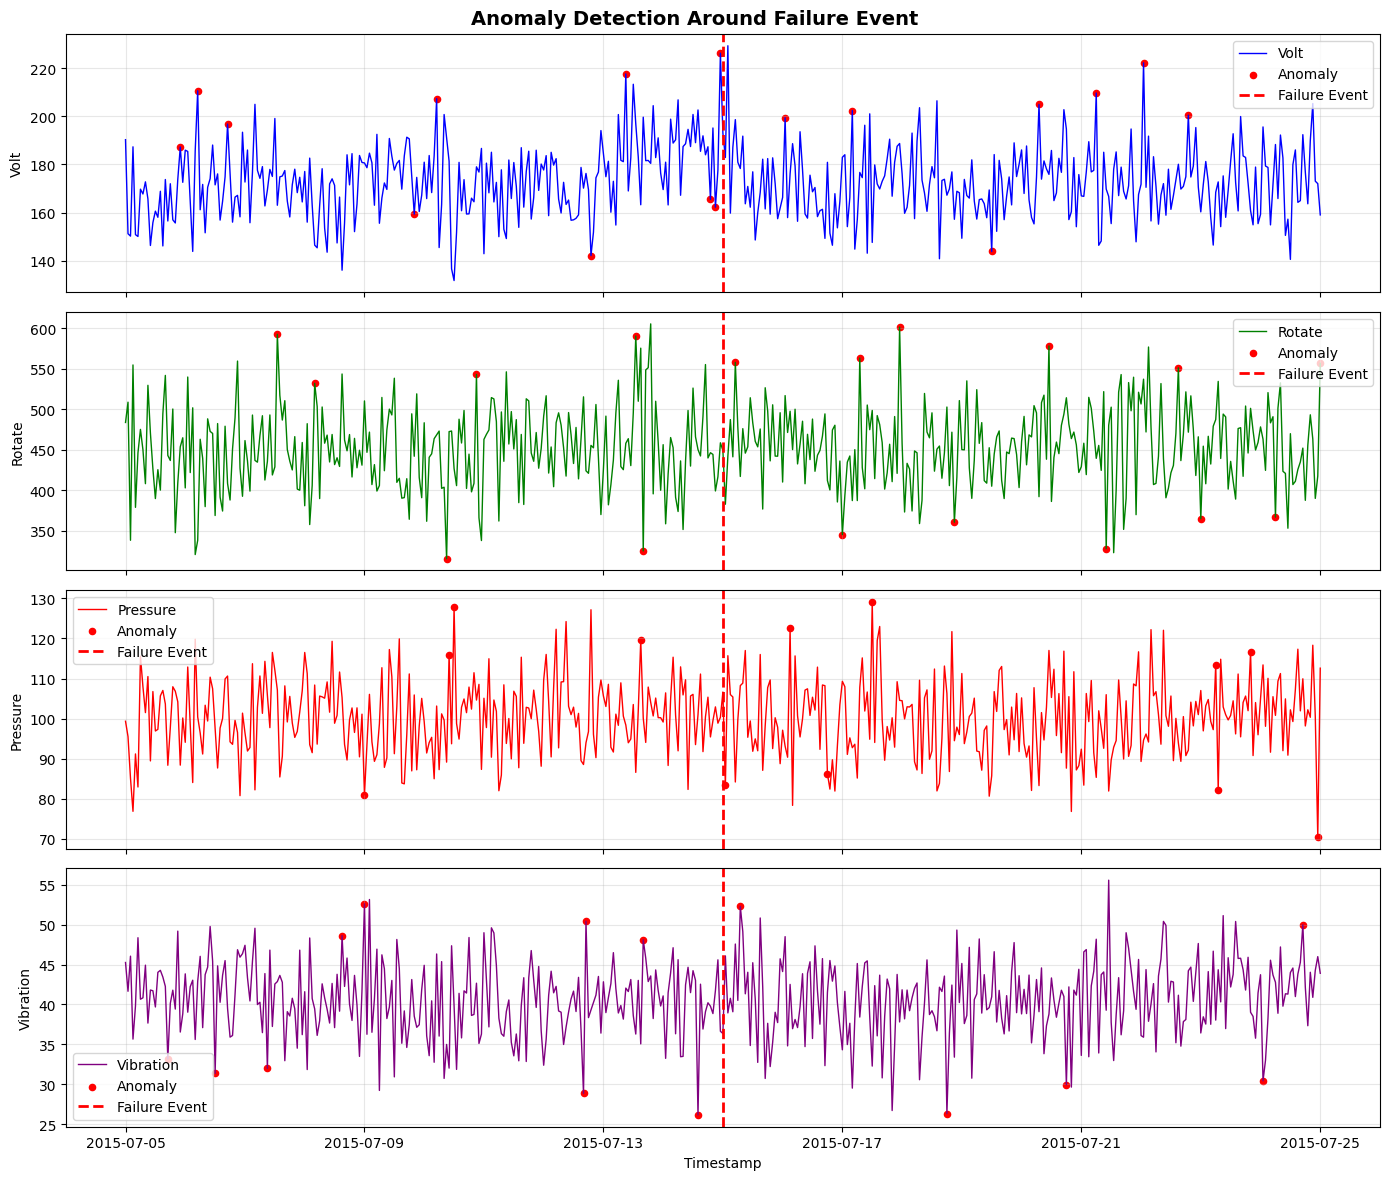

In [ ]:
df_sel['datetime'] = pd.to_datetime(df_sel['datetime'])
df_sel = df_sel.sort_values('datetime')

failure_time = df_sel.loc[st, 'datetime']


# Extracting ±10 days around failure
window_df = df_sel.loc[st-(10*24):st+(10*24)].copy()

# ROLLING ANOMALY DETECTION
sensors = ['volt', 'rotate', 'pressure', 'vibration']
colors = ['blue', 'green', 'red', 'purple'] 
window = 12        # rolling window
threshold = 2      # Z-score threshold

for sensor in sensors:
    # Rolling mean and std
    window_df[f'{sensor}_mean'] = window_df[sensor].rolling(window).mean()
    window_df[f'{sensor}_std'] = window_df[sensor].rolling(window).std()

    # Rolling z-score
    window_df[f'{sensor}_z'] = (
    (window_df[sensor] - window_df[f'{sensor}_mean']) /window_df[f'{sensor}_std']
    )

    # Anomaly flag
    window_df[f'{sensor}_anomaly'] = window_df[f'{sensor}_z'].abs() > threshold

# PLOT ANOMALIES AROUND FAILURE
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

for ax, sensor, color in zip(axes, sensors, colors):

    # Plot sensor values
    ax.plot(window_df['datetime'], window_df[sensor], color= color,label=sensor.capitalize(), linewidth=1)

    # Highlight anomalies
    anoms = window_df[window_df[f'{sensor}_anomaly']]
    ax.scatter(anoms['datetime'], anoms[sensor], color='red', s=20, label='Anomaly')

    # Vertical dotted line at failure event
    ax.axvline(failure_time, color='red', linestyle='--', linewidth=2, label='Failure Event')

    ax.set_ylabel(sensor.capitalize())
    ax.grid(alpha=0.3)
    ax.legend()

axes[-1].set_xlabel("Timestamp")
plt.suptitle("Anomaly Detection Around Failure Event", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


Using Principal Component Analysis for anamoly detection since there are more than one sensor reading for the particular machine

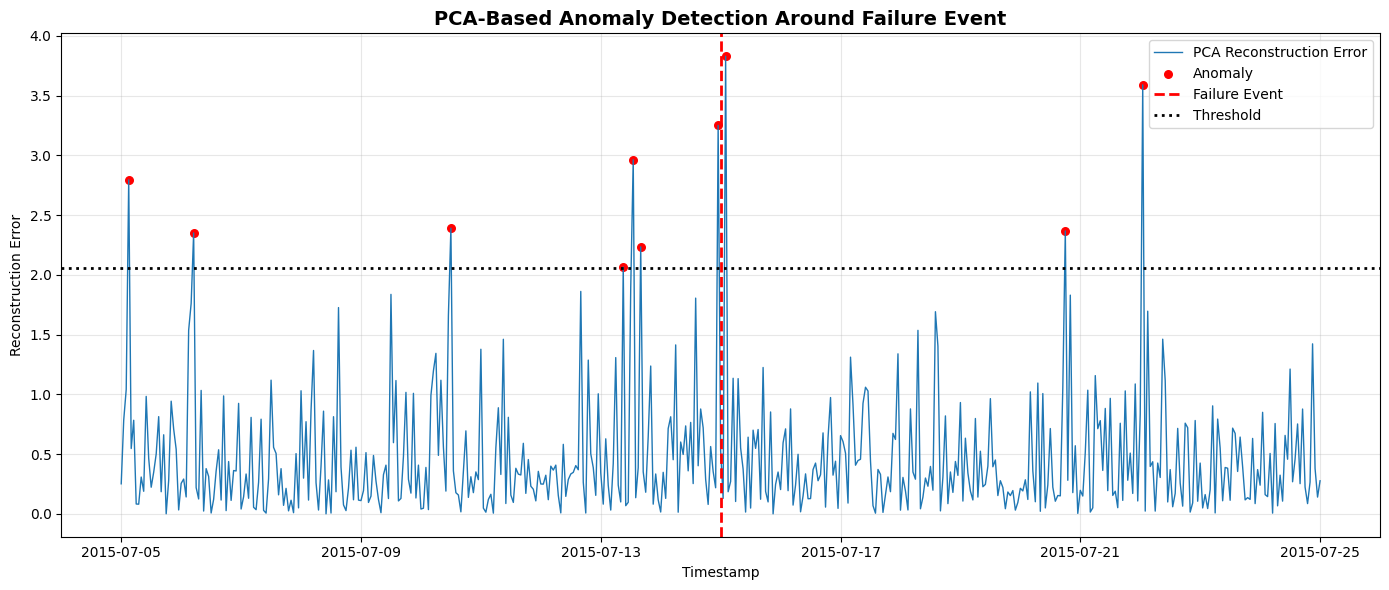

In [ ]:
sensors = ['volt', 'rotate', 'pressure', 'vibration']

# Standardize sensor data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(window_df[sensors])

# Fit PCA (2 components capture most variance)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Reconstruct data from PCA
X_reconstructed = pca.inverse_transform(X_pca)

# Reconstruction error (MSE per row)
reconstruction_error = np.mean((X_scaled - X_reconstructed)**2, axis=1)
window_df['pca_error'] = reconstruction_error

# Threshold for anomaly detection
threshold = window_df['pca_error'].mean() + 3 * window_df['pca_error'].std()
window_df['pca_anomaly'] = window_df['pca_error'] > threshold

# PLOT PCA ANOMALIES AROUND FAILURE

plt.figure(figsize=(14,6))

# Plot reconstruction error
plt.plot(window_df['datetime'], window_df['pca_error'], label='PCA Reconstruction Error', linewidth=1)

# Highlight anomalies
anoms = window_df[window_df['pca_anomaly']]
plt.scatter(anoms['datetime'], anoms['pca_error'], color='red', s=30, label='Anomaly')

# Failure event line (dotted)
plt.axvline(failure_time, color='red', linestyle='--', linewidth=2, label='Failure Event')

# Threshold line
plt.axhline(threshold, color='black', linestyle=':', linewidth=2, label='Threshold')

plt.title("PCA-Based Anomaly Detection Around Failure Event", fontsize=14, fontweight='bold')
plt.xlabel("Timestamp")
plt.ylabel("Reconstruction Error")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

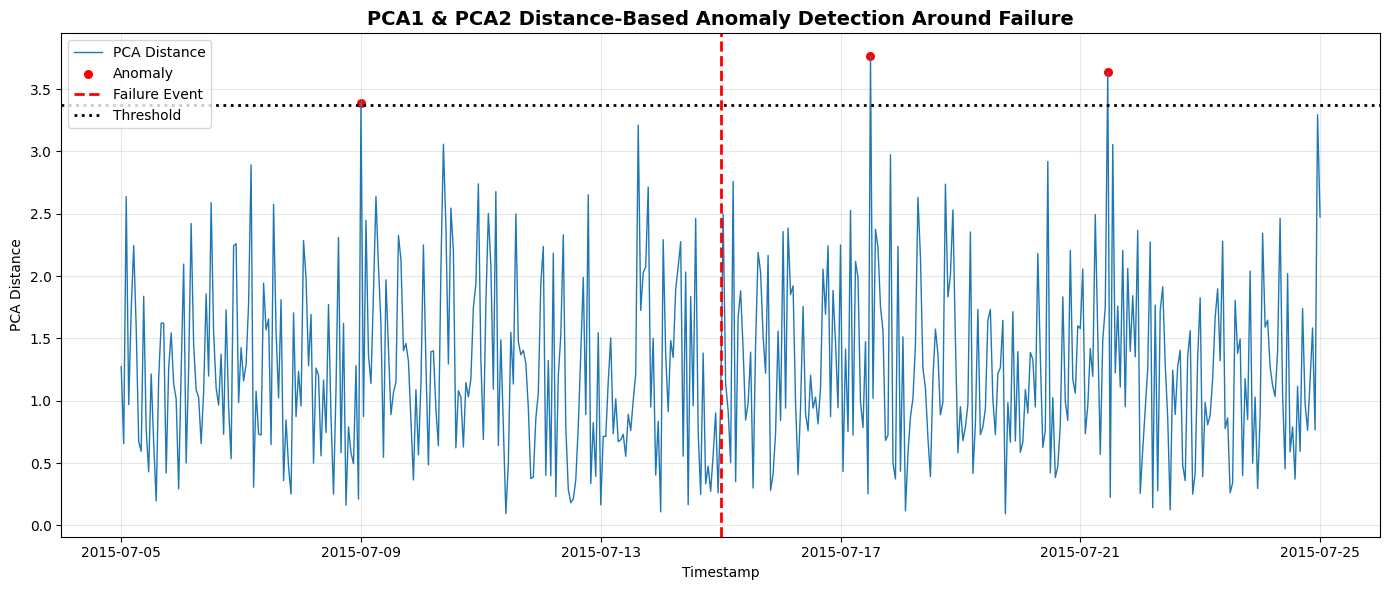

In [ ]:
sensors = ['volt', 'rotate', 'pressure', 'vibration']

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(window_df[sensors])

# PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

window_df['PC1'] = X_pca[:, 0]
window_df['PC2'] = X_pca[:, 1]

# DISTANCE-BASED ANOMALY DETECTION

# Compute PCA center
pc1_mean = window_df['PC1'].mean()
pc2_mean = window_df['PC2'].mean()

# Euclidean distance from PCA center
window_df['pca_distance'] = np.sqrt(
    (window_df['PC1'] - pc1_mean)**2 +
    (window_df['PC2'] - pc2_mean)**2
)

# Threshold = mean + 3*std
threshold = window_df['pca_distance'].mean() + 3 * window_df['pca_distance'].std()

window_df['pca_anomaly'] = window_df['pca_distance'] > threshold

# PLOT PCA DISTANCE ANOMALIES AROUND FAILURE

plt.figure(figsize=(14,6))

plt.plot(window_df['datetime'], window_df['pca_distance'],label='PCA Distance', linewidth=1)

# Highlight anomalies
anoms = window_df[window_df['pca_anomaly']]
plt.scatter(anoms['datetime'], anoms['pca_distance'], color='red', s=30, label='Anomaly')

# Failure event line
plt.axvline(failure_time, color='red', linestyle='--', linewidth=2, label='Failure Event')

# Threshold line
plt.axhline(threshold, color='black', linestyle=':', linewidth=2, label='Threshold')

plt.title("PCA1 & PCA2 Distance-Based Anomaly Detection Around Failure", fontsize=14, fontweight='bold')
plt.xlabel("Timestamp")
plt.ylabel("PCA Distance")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


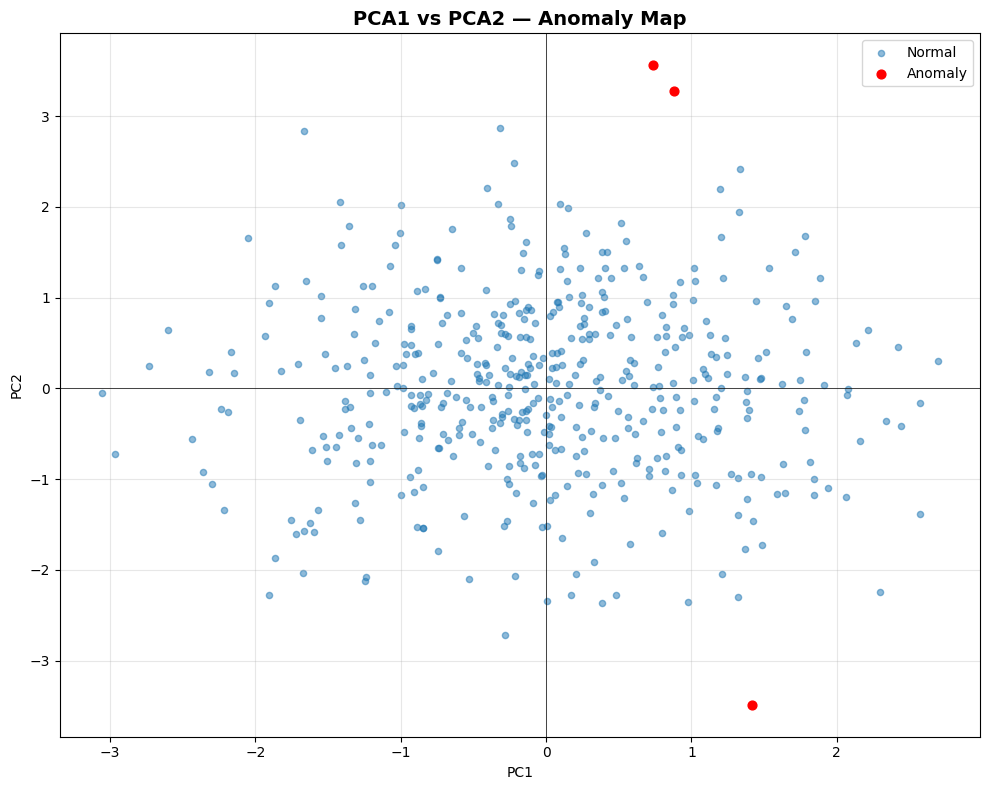

In [18]:
plt.figure(figsize=(10,8))

# Normal points
normal = window_df[~window_df['pca_anomaly']]
plt.scatter(normal['PC1'], normal['PC2'], s=20, alpha=0.5, label='Normal')

# Anomalies
anoms = window_df[window_df['pca_anomaly']]
plt.scatter(anoms['PC1'], anoms['PC2'], s=40, color='red', label='Anomaly')

plt.axvline(0, color='black', linewidth=0.5)
plt.axhline(0, color='black', linewidth=0.5)

plt.title("PCA1 vs PCA2 — Anomaly Map", fontsize=14, fontweight='bold')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
